## Gradient Boosting Regression For Student Exam Score Prediction

### Import Libraries

In [150]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score,learning_curve,validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
import matplotlib.pyplot as plt
import joblib
import os

### Loading Dataset

In [151]:
#load the data
df = pd.read_csv(r'E:\dataMining\project\StudentPerformanceFactors.csv')
df.dropna(axis =1 , inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  School_Type                 6607 non-null   object
 12  Peer_Influence              6607 non-null   object
 13  Physical_Activity           6607 non-null   int6

### Present Data

In [152]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Public,Positive,3,No,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Public,Negative,4,No,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Public,Neutral,4,No,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Public,Negative,4,No,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,Public,Neutral,4,No,Female,70


### Encode Categorical Variables

In [153]:
object_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for column in object_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

### Standardize Features

In [154]:
#Outlier Handling with Standard Deviation
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    mean = np.mean(df[col])
    std = np.std(df[col])
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

### Split Training and Test Data

In [155]:
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Gender
6406,20,72,2,2,1,9,56,2,1,4,0,1,0,2,0,1
4905,26,69,1,1,1,7,84,2,1,0,2,0,1,3,1,1
4472,28,81,2,2,1,6,96,0,1,2,1,0,2,5,0,1
5545,10,67,0,0,0,6,61,2,1,0,1,0,1,2,0,0
90,21,60,0,2,0,7,80,2,1,0,2,1,1,4,1,1


In [157]:
X_test.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Gender
3452,19,95,0,0,1,9,68,2,1,3,0,1,2,4,0,1
4995,20,72,0,2,1,7,80,2,1,1,1,0,0,3,0,1
4901,14,65,2,0,1,9,97,1,1,3,1,1,2,4,0,0
3495,32,64,1,1,1,6,97,2,1,1,2,1,1,5,0,1
97,22,81,2,2,1,7,77,1,1,2,2,1,2,3,0,0


In [158]:
#show the number of the training set and the test set
print("The number of the Training Set：", X_train.shape[0]) 
print("The number of the Test Set：", X_test.shape[0]) 

The number of the Training Set： 5204
The number of the Test Set： 1302


### Build Gradient Boosting Model

In [159]:
model = GradientBoostingRegressor(
    n_estimators=100,      
    random_state=50
)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=50)

### Cross-Validation

In [160]:
kf = KFold(n_splits=5, shuffle=True, random_state=50)
scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=scoring['r2'])
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=scoring['mse'])

### Print CV Results

In [161]:
# 输出交叉验证结果
print("===== 5-Fold Cross-Validation Results =====")
print("R² Scores:", np.round(r2_scores, 4))
print("Average R²:", np.round(np.mean(r2_scores), 2))
print("-----------------------------------")
print("MSE Scores:", np.round(mse_scores, 4))
print("Average MSE:", np.round(np.mean(mse_scores), 2))

===== 5-Fold Cross-Validation Results =====
R² Scores: [0.926  0.9138 0.9245 0.9247 0.9291]
Average R²: 0.92
-----------------------------------
MSE Scores: [0.8088 0.9397 0.8292 0.8113 0.7965]
Average MSE: 0.84


### The Curves For the model

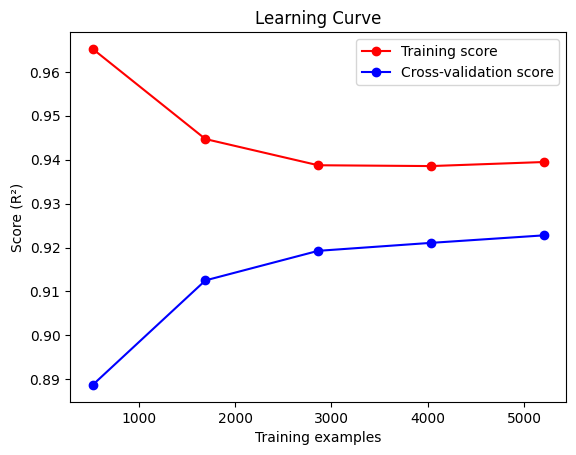

In [162]:
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score (R²)")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

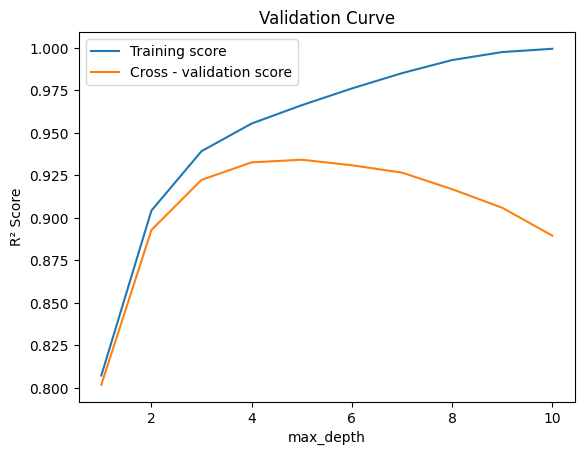

In [163]:
#Validation Curve
X = df.drop('Exam_Score', axis = 1)
y = df['Exam_Score']

param_name ='max_depth'
param_range = np.arange(1, 11)

model = GradientBoostingRegressor(random_state = 50)

train_scores, test_scores = validation_curve(
    model, X, y, param_name = param_name, param_range = param_range, cv = 5, scoring='r2'
)

train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)

plt.plot(param_range, train_scores_mean, label = 'Training score')
plt.plot(param_range, test_scores_mean, label = 'Cross - validation score')
plt.xlabel(param_name)
plt.ylabel('R² Score')
plt.title('Validation Curve')
plt.legend()
plt.show()

In [166]:
save_dir = r'E:\dataMining\project\models'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'student_performance_model.pkl')
joblib.dump(GradientBoostingRegressor, model_path)  

['E:\\dataMining\\project\\models\\student_performance_model.pkl']